# Classification, Decision Trees, and k Nearest Neighbors

## Decision Tree

A decision tree is often a generalization of the experts’ experience, a means of sharing knowledge of a particular process. For example, before the introduction of scalable machine learning algorithms, the credit scoring task in the banking sector was solved by experts. The decision to grant a loan was made on the basis of some intuitively (or empirically) derived rules that could be represented as a decision tree.

### Quality Criteria for Splits in Classification Problems

#### Entropy

Shannon's entropy is defined for a system with N possible states as follows:

$$\Large S = -\sum_{i=1}^{N}p_i \log_2{p_i},$$

where $p_i$ is the probability of finding the system in the $i$-th state.

Entropy can be described as the degree of chaos in the system.

The higher the entropy, the less ordered the system and vice versa. 

#### Gini impurity

Gini uncertainty (Gini impurity):
$$G = 1 - \sum\limits_k (p_k)^2$$
Maximizing this criterion can be interpreted as the maximization of the number of pairs of objects of the same class that are in the same subtree.

Almost identical to entropy

#### Misclassification error

Misclassification error:  
$$E = 1 - \max\limits_k p_k$$

In practice, misclassification error is almost never used.

### Example 1

If plot these two functions against the argument , we will see that the entropy plot is very close to the plot of Gini uncertainty, doubled. Therefore, in practice, these two criteria are almost identical.

In [ ]:
import warnings

warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns

sns.set()
from matplotlib import pyplot as plt

%config InlineBackend.figure_format = 'retina'

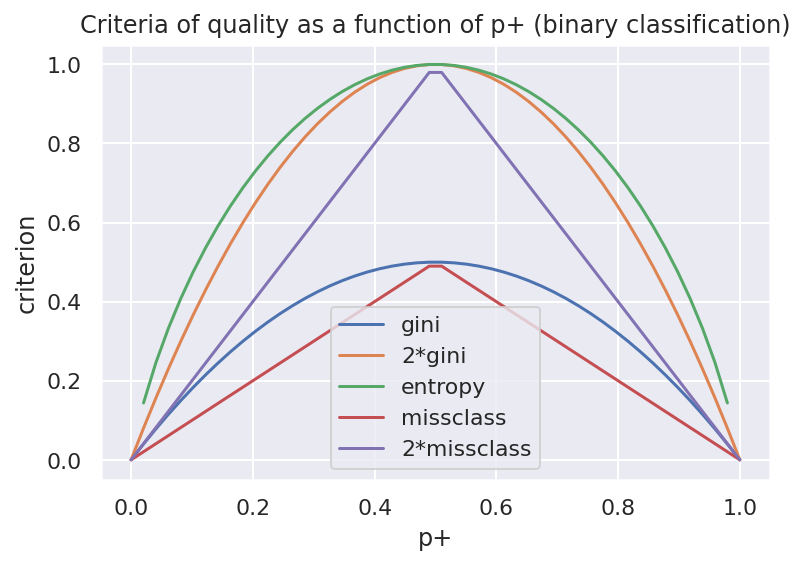

In [ ]:
plt.figure(figsize=(6, 4))
xx = np.linspace(0, 1, 50)
plt.plot(xx, [2 * x * (1 - x) for x in xx], label="gini")
plt.plot(xx, [4 * x * (1 - x) for x in xx], label="2*gini")
plt.plot(xx, [-x * np.log2(x) - (1 - x) * np.log2(1 - x) for x in xx], label="entropy")
plt.plot(xx, [1 - max(x, 1 - x) for x in xx], label="missclass")
plt.plot(xx, [2 - 2 * max(x, 1 - x) for x in xx], label="2*missclass")
plt.xlabel("p+")
plt.ylabel("criterion")
plt.title("Criteria of quality as a function of p+ (binary classification)")
plt.legend();

### Example 2

Let’s consider fitting a decision tree to some synthetic data. We will generate samples from two classes, both normal distributions but with different means.

In [ ]:
# first class
np.random.seed(17)
train_data = np.random.normal(size=(100, 2))
train_labels = np.zeros(100)

# adding second class
train_data = np.r_[train_data, np.random.normal(size=(100, 2), loc=2)]
train_labels = np.r_[train_labels, np.ones(100)]

Let’s plot the data. Informally, the classification problem in this case is to build some “good” boundary separating the two classes (the red dots from the yellow). Machine learning for this case boils down to choosing a good separating border. A straight line will be too simple while some complex curve snaking by each red dot will be too complex and will lead us to making mistakes on new samples. Intuitively, some smooth boundary, or at least a straight line or a hyperplane, would work well on new data.

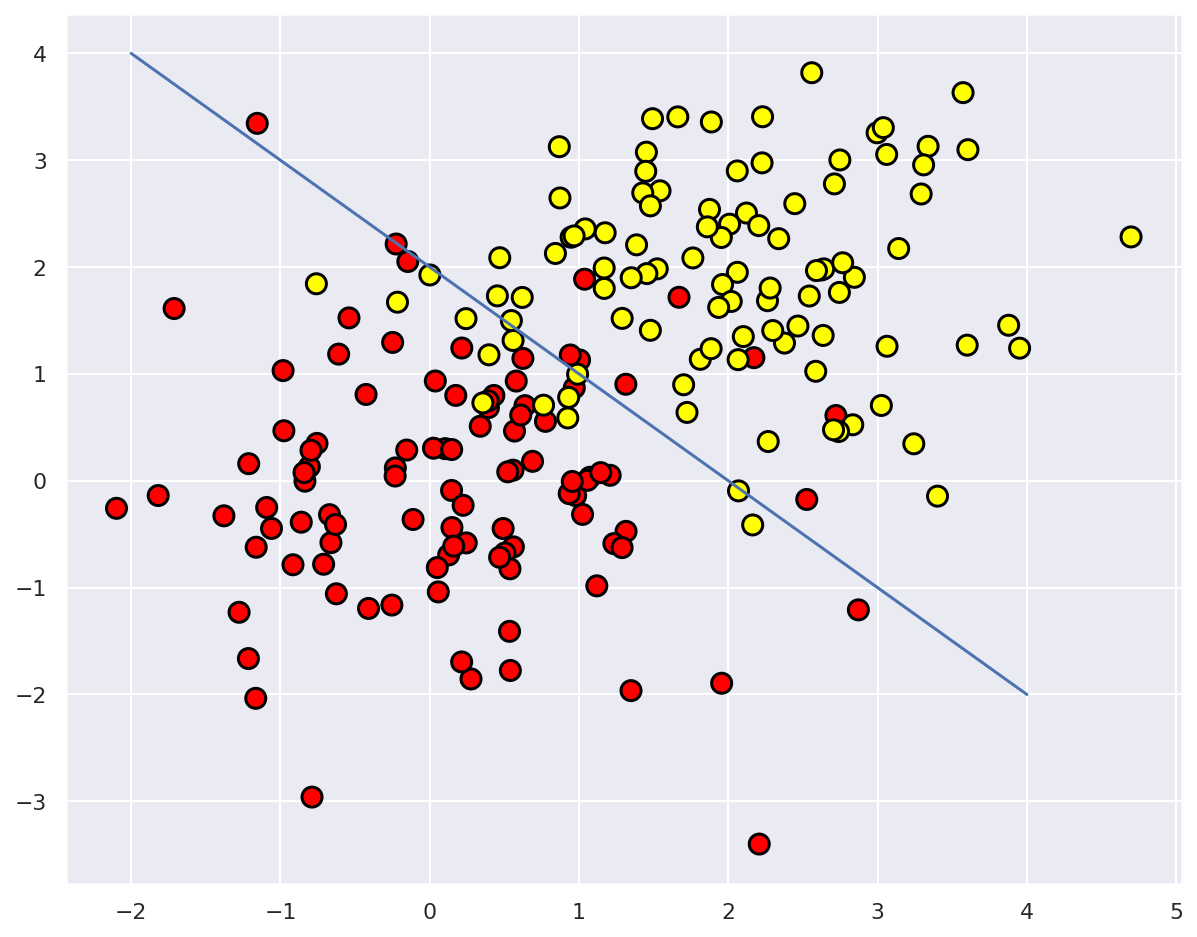

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(
    train_data[:, 0],
    train_data[:, 1],
    c=train_labels,
    s=100,
    cmap="autumn",
    edgecolors="black",
    linewidth=1.5,
)
plt.plot(range(-2, 5), range(4, -3, -1));

Let’s try to separate these two classes by training an Sklearn decision tree. We will use max_depth parameter that limits the depth of the tree. Let’s visualize the resulting separating boundary.

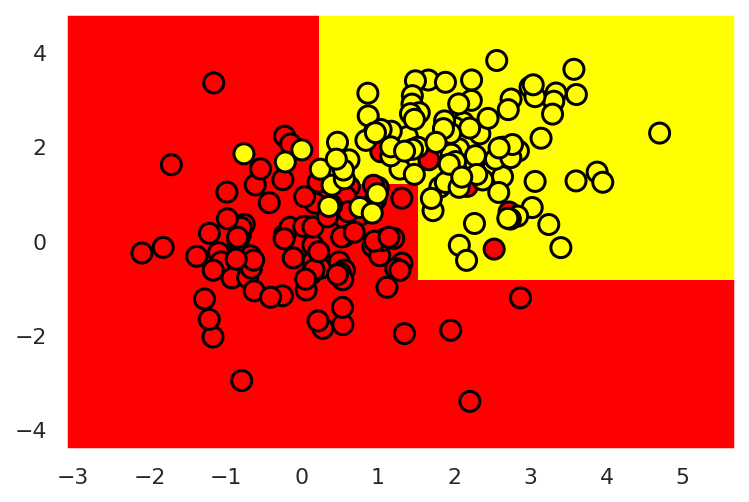

In [ ]:
from sklearn.tree import DecisionTreeClassifier


# Let’s write an auxiliary function that will return grid for further visualization.
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))


clf_tree = DecisionTreeClassifier(criterion="entropy", max_depth=3, random_state=17)

# training the tree
clf_tree.fit(train_data, train_labels)

# some code to depict separating surface
xx, yy = get_grid(train_data)
predicted = clf_tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap="autumn")
plt.scatter(
    train_data[:, 0],
    train_data[:, 1],
    c=train_labels,
    s=100,
    cmap="autumn",
    edgecolors="black",
    linewidth=1.5,
);

In [ ]:
import pydotplus  # pip install pydotplus
from sklearn.tree import export_graphviz


def tree_graph_to_png(tree, feature_names, png_file_to_save):
    tree_str = export_graphviz(
        tree, feature_names=feature_names, filled=True, out_file=None
    )
    graph = pydotplus.graph_from_dot_data(tree_str)
    graph.write_png(png_file_to_save)

In [ ]:
tree_graph_to_png(
    tree=clf_tree,
    feature_names=["x1", "x2"],
    png_file_to_save="topic3_decision_tree1.png",
)

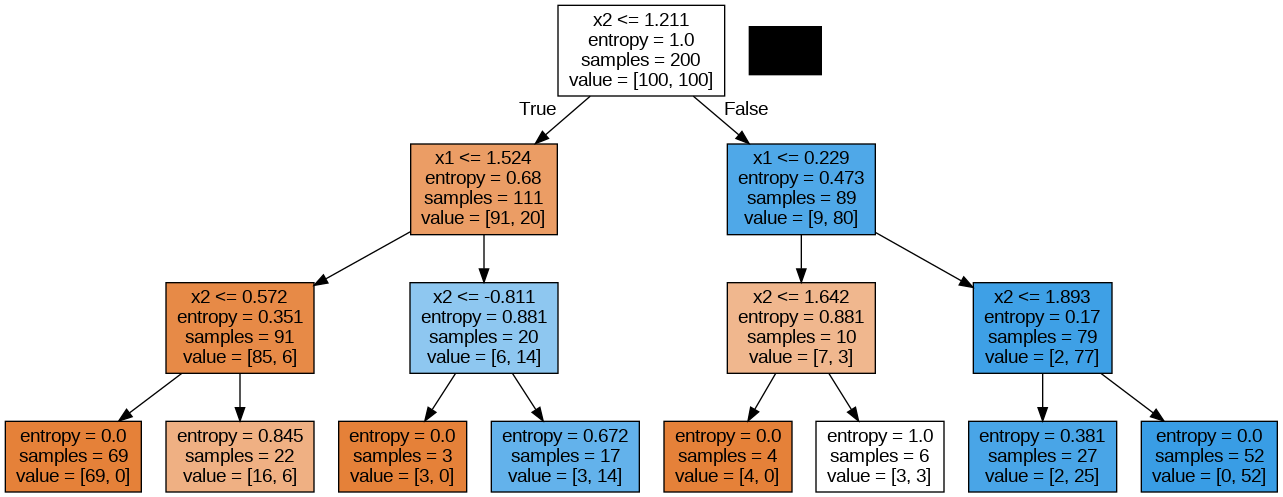

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread('topic3_decision_tree1.png')
cv2_imshow(img)

### Example 3 - numeric values

Suppose we have a numeric feature “Age” that has a lot of unique values. A decision tree will look for the best (according to some criterion of information gain) split by checking binary attributes such as “Age <17”, “Age < 22.87”, and so on. But what if the age range is large? Or what if another quantitative variable, “salary”, can also be “cut” in many ways? There will be too many binary attributes to select from at each step during tree construction. To resolve this problem, heuristics are usually used to limit the number of thresholds to which we compare the quantitative variable.

In [ ]:
data = pd.DataFrame(
    {
        "Age": [17, 64, 18, 20, 38, 49, 55, 25, 29, 31, 33],
        "Loan Default": [1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1],
    }
)
data

,Age,Loan Default
0,17,1
1,64,0
2,18,1
3,20,0
4,38,1
5,49,0
6,55,0
7,25,1
8,29,1
9,31,0


In [ ]:
data.sort_values("Age")

,Age,Loan Default
0,17,1
2,18,1
3,20,0
7,25,1
8,29,1
9,31,0
10,33,1
4,38,1
5,49,0
6,55,0


In [ ]:
age_tree = DecisionTreeClassifier(random_state=17)
age_tree.fit(data["Age"].values.reshape(-1, 1), data["Loan Default"].values)

tree_graph_to_png(
    age_tree,
    feature_names=["Age"],
    png_file_to_save="topic3_decision_tree2.png",
)

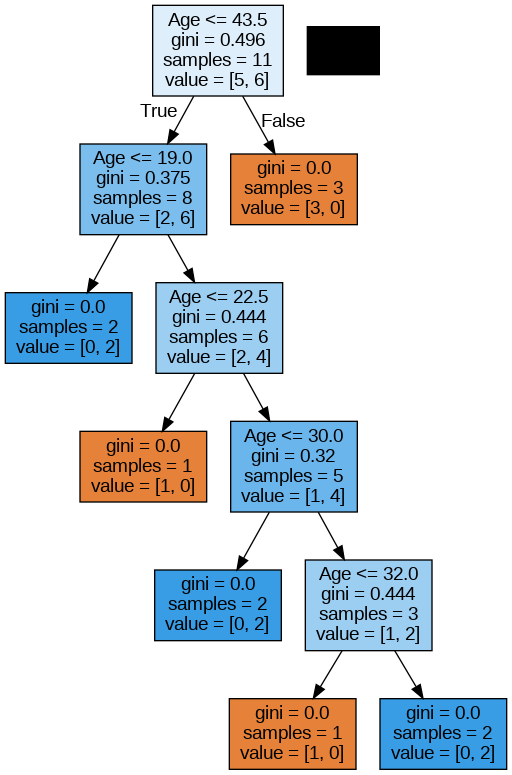

In [ ]:
img = cv2.imread('topic3_decision_tree2.png')
cv2_imshow(img)

Let’s consider a more complex example by adding the “Salary” variable (in the thousands of dollars per year).

In [ ]:
data2 = pd.DataFrame(
    {
        "Age": [17, 64, 18, 20, 38, 49, 55, 25, 29, 31, 33],
        "Salary": [25, 80, 22, 36, 37, 59, 74, 70, 33, 102, 88],
        "Loan Default": [1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1],
    }
)
data2

,Age,Salary,Loan Default
0,17,25,1
1,64,80,0
2,18,22,1
3,20,36,0
4,38,37,1
5,49,59,0
6,55,74,0
7,25,70,1
8,29,33,1
9,31,102,0


In [ ]:
data2.sort_values("Age")

,Age,Salary,Loan Default
0,17,25,1
2,18,22,1
3,20,36,0
7,25,70,1
8,29,33,1
9,31,102,0
10,33,88,1
4,38,37,1
5,49,59,0
6,55,74,0


In [ ]:
age_sal_tree = DecisionTreeClassifier(random_state=17)
age_sal_tree.fit(data2[["Age", "Salary"]].values, data2["Loan Default"].values);

In [ ]:
tree_graph_to_png(
    tree=age_sal_tree,
    feature_names=["Age", "Salary"],
    png_file_to_save="topic3_decision_tree3.png",
)

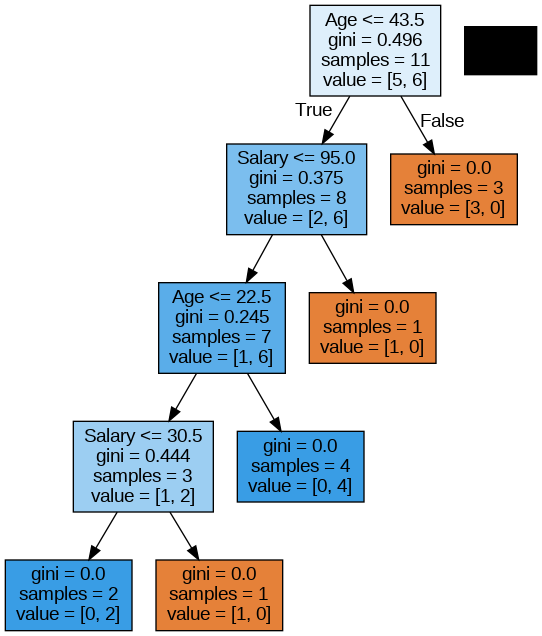

In [ ]:
img = cv2.imread('topic3_decision_tree3.png')
cv2_imshow(img)

### Crucial Tree Parameters

Technically, you can build a decision tree until each leaf has exactly one instance, but this is not common in practice when building a single tree because it will be overfitted, or too tuned to the training set, and will not predict labels for new data well.

There are two exceptions where the trees are built to the maximum depth:

* Random Forest (a group of trees) averages the responses from individual trees that are built to the maximum depth (we will talk later on why you should do this)

* Pruning trees. In this approach, the tree is first constructed to the maximum depth. Then, from the bottom up, some nodes of the tree are removed by comparing the quality of the tree with and without that partition (comparison is performed using cross-validation, more on this below).


Class DecisionTreeClassifier in Scikit-learn
The main parameters of the sklearn.tree.DecisionTreeClassifier class are:

* max_depth – the maximum depth of the tree;

* max_features - the maximum number of features with which to search for the best partition (this is necessary with a large number of features because it would be “expensive” to search for partitions for all features);

* min_samples_leaf – the minimum number of samples in a leaf. This parameter prevents creating trees where any leaf would have only a few members.

The parameters of the tree need to be set depending on input data, and it is usually done by means of cross-validation

### Decision Tree in a Regression Problem

When predicting a numeric variable, the idea of a tree construction remains the same, but the quality criteria changes:

Variance: 

$$\Large D = \frac{1}{\ell} \sum\limits_{i =1}^{\ell} (y_i - \frac{1}{\ell} \sum\limits_{j=1}^{\ell} y_j)^2, $$

where $\ell$ is the number of samples in a leaf, $y_i$ is the value of the target variable. Simply put, by minimizing the variance, we look for features that divide the training set in such a way that the values of the target feature in each leaf are roughly equal.

#### Example

Let's generate some data distributed by the function $f(x) = e^{-x ^ 2} + 1.5 * e^{-(x - 2) ^ 2}$ with some noise. Then we will train a tree with this data and predictions that the tree makes.

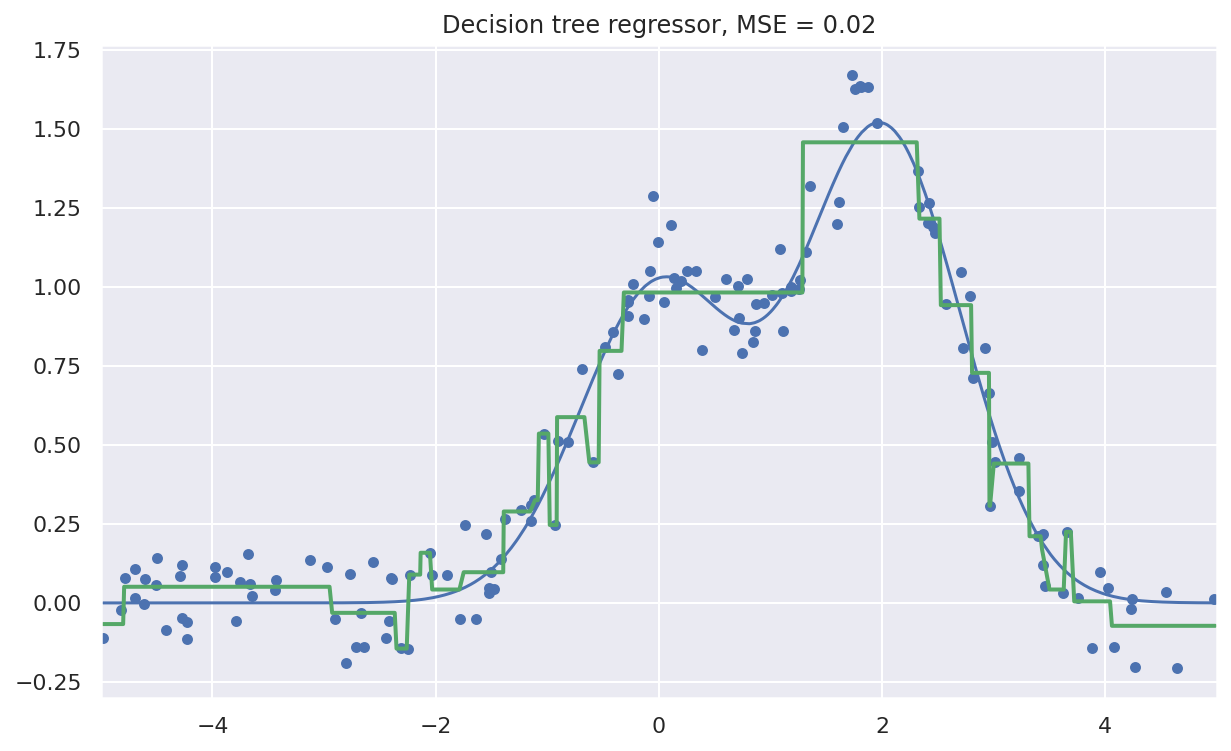

In [ ]:
n_train = 150
n_test = 1000
noise = 0.1


def f(x):
    x = x.ravel()
    return np.exp(-(x ** 2)) + 1.5 * np.exp(-((x - 2) ** 2))


def generate(n_samples, noise):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X).ravel()
    y = (
        np.exp(-(X ** 2))
        + 1.5 * np.exp(-((X - 2) ** 2))
        + np.random.normal(0.0, noise, n_samples)
    )
    X = X.reshape((n_samples, 1))
    return X, y


X_train, y_train = generate(n_samples=n_train, noise=noise)
X_test, y_test = generate(n_samples=n_test, noise=noise)

from sklearn.tree import DecisionTreeRegressor

reg_tree = DecisionTreeRegressor(max_depth=5, random_state=17)

reg_tree.fit(X_train, y_train)
reg_tree_pred = reg_tree.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, reg_tree_pred, "g", lw=2)
plt.xlim([-5, 5])
plt.title(
    "Decision tree regressor, MSE = %.2f"
    % (np.sum((y_test - reg_tree_pred) ** 2) / n_test)
)
plt.show()

## Nearest Neighbors Method

The underlying intuition is that you look like your neighbors. More formally, the method follows the compactness hypothesis: if the distance between the examples is measured well enough, then similar examples are much more likely to belong to the same class.

To classify each sample from the test set, one needs to perform the following operations in order:

1. Calculate the distance to each of the samples in the training set.

2. Select  samples from the training set with the minimal distance to them.

3. The class of the test sample will be the most frequent class among those  nearest neighbors.

### Parameters

Class KNeighborsClassifier in Scikit-learn

The main parameters of the class sklearn.neighbors.KNeighborsClassifier are:

* weights: uniform (all weights are equal), distance (the weight is inversely proportional to the distance from the test sample), or any other user-defined function;

* algorithm (optional): brute, ball_tree , KD_tree, or auto. In the first case, the nearest neighbors for each test case are computed by a grid search over the training set. In the second and third cases, the distances between the examples are stored in a tree to accelerate finding nearest neighbors. If you set this parameter to auto, the right way to find the neighbors will be automatically chosen based on the training set.

* leaf_size (optional): threshold for switching to grid search if the algorithm for finding neighbors is BallTree or KDTree;

* metric: minkowski, manhattan , euclidean, chebyshev, or other.

## Choosing Model Parameters and Cross-Validation

The main task of learning algorithms is to be able to generalize to unseen data. Since we cannot immediately check the model performance on new, incoming data (because we do not know the true values of the target variable yet), it is necessary to sacrifice a small portion of the data to check the quality of the model on it.

This is often done in one of two ways:

* setting aside a part of the dataset (held-out/hold-out set). Thus we reserve a fraction of the training set (typically from 20% to 40%), train the model on the remaining data (60-80% of the original set), and compute performance metrics for the model (e.g accuracy) on the hold-out set.

* cross-validation. The most frequent case here is k-fold cross-validation.

<img src="https://mlcourse.ai/_images/cross_validation.png">

## Application Examples and Complex Cases

Decision trees and nearest neighbors method in a customer churn prediction task

In [ ]:
# for Jupyter-book, we copy data from GitHub, locally, to save Internet traffic,
# you can specify the data/ folder from the root of your cloned
# https://github.com/Yorko/mlcourse.ai repo, to save Internet traffic
DATA_PATH = "https://raw.githubusercontent.com/Yorko/mlcourse.ai/master/data/"

In [ ]:
df = pd.read_csv(DATA_PATH + "telecom_churn.csv")

df["International plan"] = pd.factorize(df["International plan"])[0]
df["Voice mail plan"] = pd.factorize(df["Voice mail plan"])[0]
df["Churn"] = df["Churn"].astype("int")
states = df["State"]
y = df["Churn"]
df.drop(["State", "Churn"], axis=1, inplace=True)

In [ ]:
df.head()

,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
0,128,415,0,0,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,107,415,0,0,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1
2,137,415,0,1,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0
3,84,408,1,1,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2
4,75,415,1,1,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3


In [ ]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

X_train, X_holdout, y_train, y_holdout = train_test_split(
    df.values, y, test_size=0.3, random_state=17
)

tree = DecisionTreeClassifier(max_depth=5, random_state=17)
knn = KNeighborsClassifier(n_neighbors=10)

tree.fit(X_train, y_train)

# for kNN, we need to scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_holdout_scaled = scaler.transform(X_holdout)
knn.fit(X_train_scaled, y_train);

In [ ]:
from sklearn.metrics import accuracy_score

tree_pred = tree.predict(X_holdout)
accuracy_score(y_holdout, tree_pred)  # 0.94

0.94

In [ ]:
knn_pred = knn.predict(X_holdout_scaled)
accuracy_score(y_holdout, knn_pred)  # 0.89

0.89

In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_score

tree_params = {"max_depth": range(1, 11), "max_features": range(4, 19)}

tree_grid = GridSearchCV(tree, tree_params, cv=5, n_jobs=-1, verbose=True)

tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=5, random_state=17),
             n_jobs=-1,
             param_grid={'max_depth': range(1, 11),
                         'max_features': range(4, 19)},
             verbose=True)

In [ ]:
tree_grid.best_params_  # {'max_depth': 6, 'max_features': 17}

{'max_depth': 6, 'max_features': 17}

In [ ]:
tree_grid.best_score_  # 0.94256322331761677

0.94257014456259

In [ ]:
accuracy_score(y_holdout, tree_grid.predict(X_holdout))  # 0.946

0.946

In [ ]:
tree_graph_to_png(
    tree=tree_grid.best_estimator_,
    feature_names=df.columns,
    png_file_to_save="topic3_decision_tree4.png",
)

In [ ]:
from sklearn.pipeline import Pipeline

knn_pipe = Pipeline(
    [("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_jobs=-1))]
)

knn_params = {"knn__n_neighbors": range(1, 10)}

knn_grid = GridSearchCV(knn_pipe, knn_params, cv=5, n_jobs=-1, verbose=True)

knn_grid.fit(X_train, y_train)

knn_grid.best_params_, knn_grid.best_score_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


({'knn__n_neighbors': 7}, 0.8859867109023905)

In [ ]:
accuracy_score(y_holdout, knn_grid.predict(X_holdout))  # 0.89

0.89

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=17)
print(np.mean(cross_val_score(forest, X_train, y_train, cv=5)))  # 0.949

0.9494233119813256


In [ ]:
forest_params = {"max_depth": range(6, 12), "max_features": range(4, 19)}

forest_grid = GridSearchCV(forest, forest_params, cv=5, n_jobs=-1, verbose=True)

forest_grid.fit(X_train, y_train)

forest_grid.best_params_, forest_grid.best_score_  # ({'max_depth': 9, 'max_features': 6}, 0.951)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


({'max_depth': 9, 'max_features': 6}, 0.9511372931045574)

In [ ]:
accuracy_score(y_holdout, forest_grid.predict(X_holdout))  # 0.953

0.953

## Complex Case for Decision Trees

To continue the discussion of the pros and cons of the methods in question, let’s consider a simple classification task, where a tree would perform well but does it in an “overly complicated” manner. Let’s create a set of points on a plane (2 features), each point will be one of two classes (+1 for red, or -1 for yellow). If you look at it as a classification problem, it seems very simple: the classes are separated by a line.



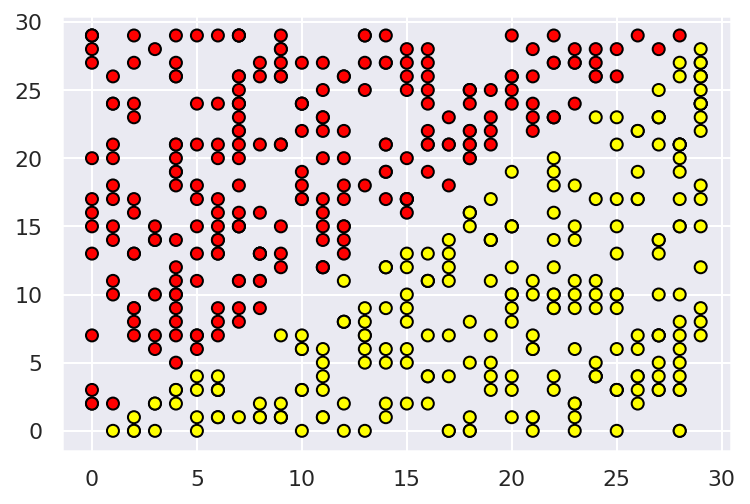

In [ ]:
def form_linearly_separable_data(n=500, x1_min=0, x1_max=30, x2_min=0, x2_max=30):
    data, target = [], []
    for i in range(n):
        x1 = np.random.randint(x1_min, x1_max)
        x2 = np.random.randint(x2_min, x2_max)
        if np.abs(x1 - x2) > 0.5:
            data.append([x1, x2])
            target.append(np.sign(x1 - x2))
    return np.array(data), np.array(target)


X, y = form_linearly_separable_data()

plt.scatter(X[:, 0], X[:, 1], c=y, cmap="autumn", edgecolors="black");

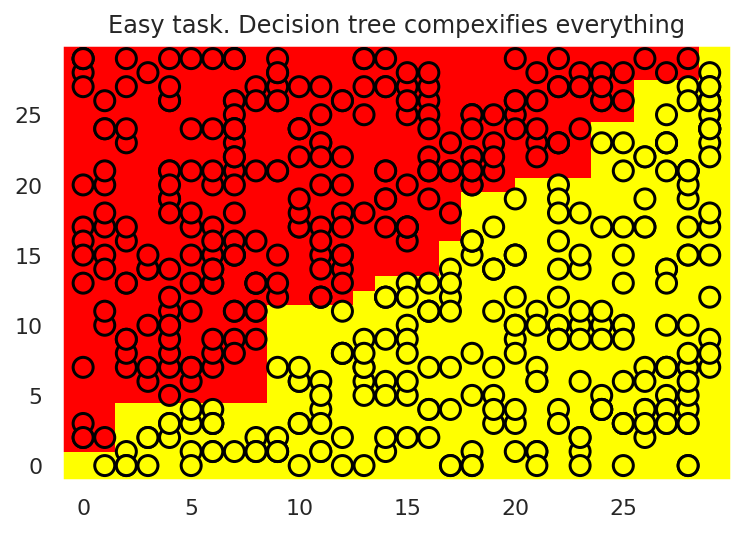

In [ ]:
tree = DecisionTreeClassifier(random_state=17).fit(X, y)

xx, yy = get_grid(X)
predicted = tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap="autumn")
plt.scatter(
    X[:, 0], X[:, 1], c=y, s=100, cmap="autumn", edgecolors="black", linewidth=1.5
)
plt.title("Easy task. Decision tree compexifies everything");

In [ ]:
tree_graph_to_png(
    tree=tree,
    feature_names=["x1", "x2"],
    png_file_to_save="topic3_decision_tree5.png",
)

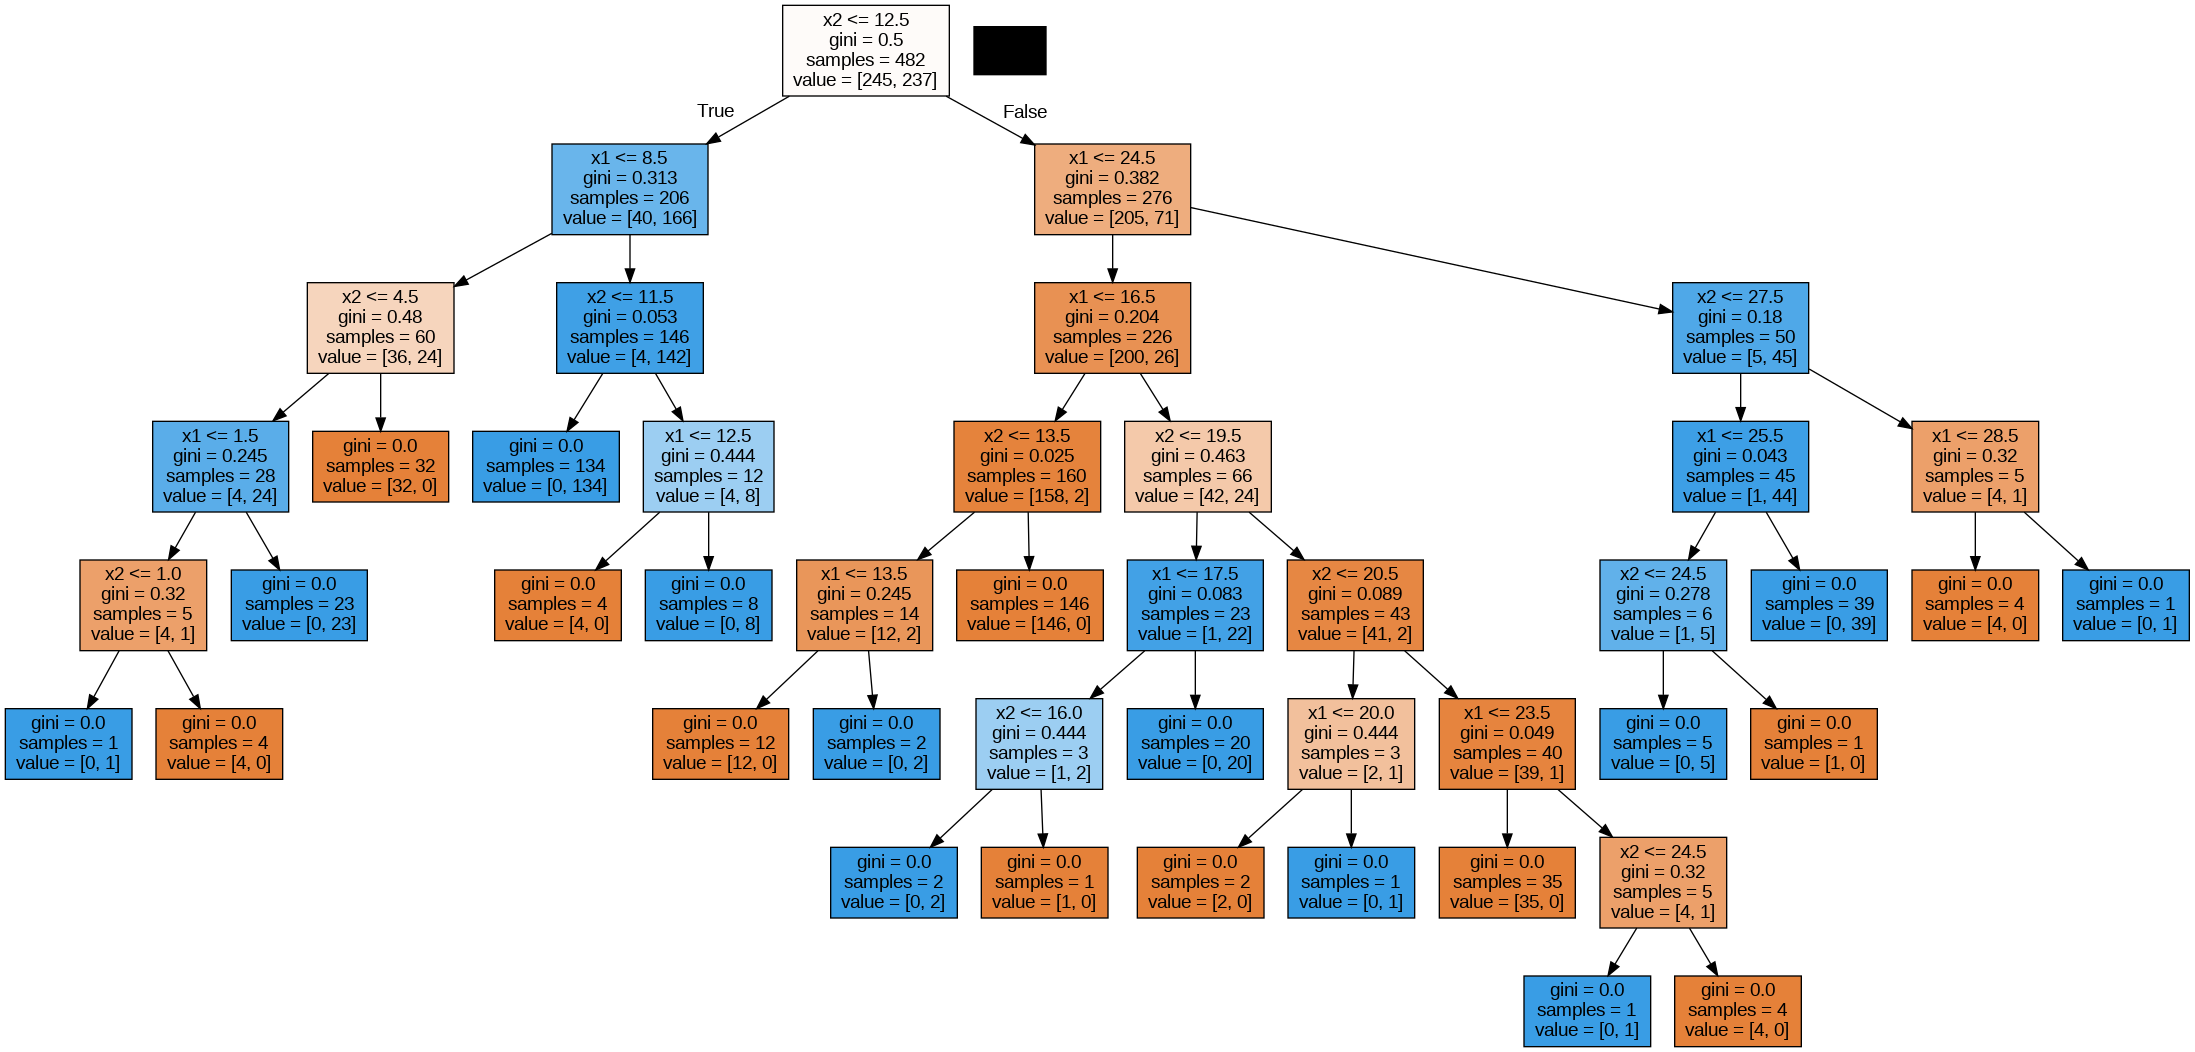

In [ ]:
img = cv2.imread('topic3_decision_tree5.png')
cv2_imshow(img)

The method of one nearest neighbor does better than the tree but is still not as good as a linear classifier

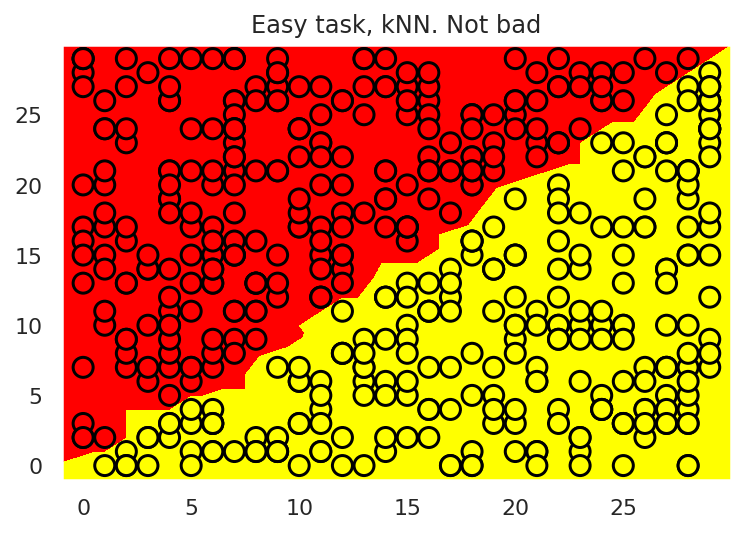

In [ ]:
knn = KNeighborsClassifier(n_neighbors=1).fit(X, y)

xx, yy = get_grid(X)
predicted = knn.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap="autumn")
plt.scatter(
    X[:, 0], X[:, 1], c=y, s=100, cmap="autumn", edgecolors="black", linewidth=1.5
)
plt.title("Easy task, kNN. Not bad");

## Decision Trees and k-NN in a Task of MNIST Handwritten Digits Recognition

Now let’s have a look at how these 2 algorithms perform on a real-world task. We will use the sklearn built-in dataset on handwritten digits. This task is an example where k-NN works surprisingly well.

Pictures here are 8x8 matrices (intensity of white color for each pixel). Then each such matrix is ​​“unfolded” into a vector of length 64, and we obtain a feature description of an object.

Let’s draw some handwritten digits. We see that they are distinguishable.

In [ ]:
from sklearn.datasets import load_digits

data = load_digits()
X, y = data.data, data.target

X[0, :].reshape([8, 8])

In [ ]:
f, axes = plt.subplots(1, 4, sharey=True, figsize=(16, 6))
for i in range(4):
    axes[i].imshow(X[i, :].reshape([8, 8]), cmap="Greys");

In [ ]:
X_train, X_holdout, y_train, y_holdout = train_test_split(
    X, y, test_size=0.3, random_state=17
)

In [ ]:
tree = DecisionTreeClassifier(max_depth=5, random_state=17)
knn_pipe = Pipeline(
    [("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=10))]
)

tree.fit(X_train, y_train)
knn_pipe.fit(X_train, y_train);

In [ ]:
tree_pred = tree.predict(X_holdout)
knn_pred = knn_pipe.predict(X_holdout)
accuracy_score(y_holdout, knn_pred), accuracy_score(
    y_holdout, tree_pred
)  # (0.976, 0.666)

In [ ]:
tree_params = {
    "max_depth": [1, 2, 3, 5, 10, 20, 25, 30, 40, 50, 64],
    "max_features": [1, 2, 3, 5, 10, 20, 30, 50, 64],
}

tree_grid = GridSearchCV(tree, tree_params, cv=5, n_jobs=-1, verbose=True)

tree_grid.fit(X_train, y_train)

In [ ]:
tree_grid.best_params_, tree_grid.best_score_  # ({'max_depth': 20, 'max_features': 64}, 0.844)

({'max_depth': 10, 'max_features': 50}, 0.8568203376968316)

In [ ]:
np.mean(
    cross_val_score(KNeighborsClassifier(n_neighbors=1), X_train, y_train, cv=5)
)  # 0.987

0.9864858028204642

## Complex Case for the Nearest Neighbors Method

Let’s consider another simple example. In the classification problem, one of the features will just be proportional to the vector of responses, but this won’t help for the nearest neighbors method.

In [ ]:
def form_noisy_data(n_obj=1000, n_feat=100, random_seed=17):
    np.seed = random_seed
    y = np.random.choice([-1, 1], size=n_obj)

    # first feature is proportional to target
    x1 = 0.3 * y

    # other features are noise

    x_other = np.random.random(size=[n_obj, n_feat - 1])

    return np.hstack([x1.reshape([n_obj, 1]), x_other]), y


X, y = form_noisy_data()

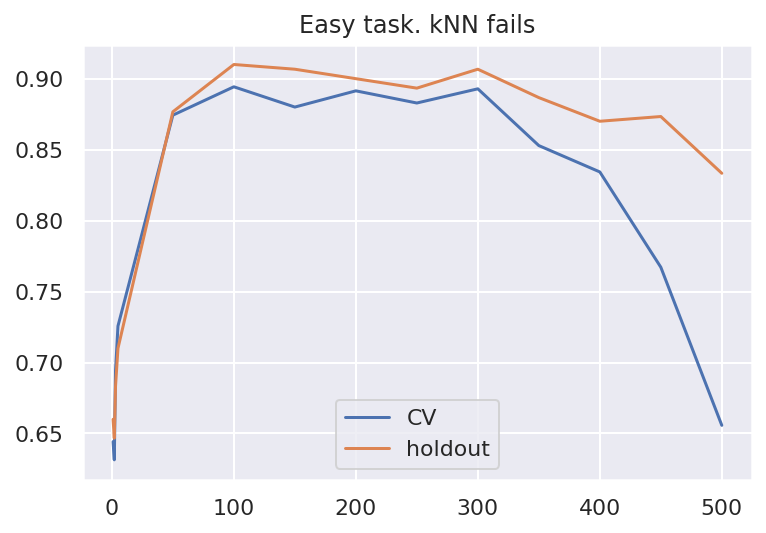

In [ ]:
X_train, X_holdout, y_train, y_holdout = train_test_split(
    X, y, test_size=0.3, random_state=17
)

from sklearn.model_selection import cross_val_score

cv_scores, holdout_scores = [], []
n_neighb = [1, 2, 3, 5] + list(range(50, 550, 50))

for k in n_neighb:

    knn_pipe = Pipeline(
        [("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=k))]
    )
    cv_scores.append(np.mean(cross_val_score(knn_pipe, X_train, y_train, cv=5)))
    knn_pipe.fit(X_train, y_train)
    holdout_scores.append(accuracy_score(y_holdout, knn_pipe.predict(X_holdout)))

plt.plot(n_neighb, cv_scores, label="CV")
plt.plot(n_neighb, holdout_scores, label="holdout")
plt.title("Easy task. kNN fails")
plt.legend();

In [ ]:
tree = DecisionTreeClassifier(random_state=17, max_depth=1)
tree_cv_score = np.mean(cross_val_score(tree, X_train, y_train, cv=5))
tree.fit(X_train, y_train)
tree_holdout_score = accuracy_score(y_holdout, tree.predict(X_holdout))
print("Decision tree. CV: {}, holdout: {}".format(tree_cv_score, tree_holdout_score))

Decision tree. CV: 1.0, holdout: 1.0
Decision tree. CV: 1.0, holdout: 1.0


## Pros and Cons of Decision Trees and the Nearest Neighbors Method


Decision trees
* Pros:

 * Generation of clear human-understandable classification rules, e.g. “if age <25 and is interested in motorcycles, deny the loan”. This property is called interpretability of the model.

 * Decision trees can be easily visualized, i.e. both the model itself (the tree) and prediction for a certain test object (a path in the tree) can “be interpreted”.

 * Fast training and forecasting.

 * Small number of model parameters.

 * Supports both numerical and categorical features.

* Cons:

 * The trees are very sensitive to the noise in input data; the whole model could change if the training set is slightly modified (e.g. remove a feature, add some objects). This impairs the interpretability of the model.

 * Separating border built by a decision tree has its limitations – it consists of hyperplanes perpendicular to one of the coordinate axes, which is inferior in quality to some other methods, in practice.

 * We need to avoid overfitting by pruning, setting a minimum number of samples in each leaf, or defining a maximum depth for the tree. Note that overfitting is an issue for all machine learning methods.

 * Instability. Small changes to the data can significantly change the decision tree. This problem is tackled with decision tree ensembles (discussed next time).

 * The optimal decision tree search problem is NP-complete. Some heuristics are used in practice such as greedy search for a feature with maximum information gain, but it does not guarantee finding the globally optimal tree.

 * Difficulties to support missing values in the data. Friedman estimated that it took about 50% of the code to support gaps in data in CART (an improved version of this algorithm is implemented in sklearn).

 * The model can only interpolate but not extrapolate (the same is true for random forests and tree boosting). That is, a decision tree makes constant prediction for the objects that lie beyond the bounding box set by the training set in the feature space. In our example with the yellow and blue balls, it would mean that the model gives the same predictions for all balls with positions >19 or <0.



The nearest neighbors method
* Pros:

 * Simple implementation;

 * Well studied;

 * Typically, the method is a good first solution not only for classification or regression, but also recommendations;

 * It can be adapted to a certain problem by choosing the right metrics or kernel (in a nutshell, the kernel may set the similarity operation for complex objects such as graphs while keeping the k-NN approach the same). By the way, Alexander Dyakonov, a former top-1 kaggler, loves the simplest k-NN but with the tuned object similarity metric;

 * Good interpretability. There are exceptions: if the number of neighbors is large, the interpretability deteriorates (“We did not give him a loan, because he is similar to the 350 clients, of which 70 are the bad, and that is 12% higher than the average for the dataset”).

* Cons:

 * Method considered fast in comparison with compositions of algorithms, but the number of neighbors used for classification is usually large (100-150) in real life, in which case the algorithm will not operate as fast as a decision tree.

 * If a dataset has many variables, it is difficult to find the right weights and to determine which features are not important for classification/regression.

 * Dependency on the selected distance metric between the objects. Selecting the Euclidean distance by default is often unfounded. You can find a good solution by grid searching over parameters, but this becomes very time consuming for large datasets.

 * There are no theoretical ways to choose the number of neighbors – only grid search (though this is often true for all hyperparameters of all models). In the case of a small number of neighbors, the method is sensitive to outliers, that is, it is inclined to overfit.

 * As a rule, it does not work well when there are a lot of features due to the “curse of dimensionality”. Professor Pedro Domingos, a well-known member in the ML community, talks about it here in his popular paper, “A Few Useful Things to Know about Machine Learning”; also “the curse of dimensionality” is described in the Deep Learning book in this chapter.

# Assignment #3 (demo). Decision trees with a toy task and the UCI Adult dataset

## Part 1

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (10, 8)
import collections
from io import StringIO

import numpy as np
import pandas as pd
import pydotplus  # pip install pydotplus
import seaborn as sns
from ipywidgets import Image
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [ ]:
# Create dataframe with dummy variables
def create_df(dic, feature_list):
    out = pd.DataFrame(dic)
    out = pd.concat([out, pd.get_dummies(out[feature_list])], axis=1)
    out.drop(feature_list, axis=1, inplace=True)
    return out


# Some feature values are present in train and absent in test and vice-versa.
def intersect_features(train, test):
    common_feat = list(set(train.keys()) & set(test.keys()))
    return train[common_feat], test[common_feat]

In [ ]:
features = ["Looks", "Alcoholic_beverage", "Eloquence", "Money_spent"]

In [ ]:
# Training data

df_train = {}
df_train["Looks"] = [
    "handsome",
    "handsome",
    "handsome",
    "repulsive",
    "repulsive",
    "repulsive",
    "handsome",
]
df_train["Alcoholic_beverage"] = ["yes", "yes", "no", "no", "yes", "yes", "yes"]
df_train["Eloquence"] = ["high", "low", "average", "average", "low", "high", "average"]
df_train["Money_spent"] = ["lots", "little", "lots", "little", "lots", "lots", "lots"]
df_train["Will_go"] = LabelEncoder().fit_transform(["+", "-", "+", "-", "-", "+", "+"])

df_train = create_df(df_train, features)
df_train

,Will_go,Looks_handsome,Looks_repulsive,Alcoholic_beverage_no,Alcoholic_beverage_yes,Eloquence_average,Eloquence_high,Eloquence_low,Money_spent_little,Money_spent_lots
0,0,1,0,0,1,0,1,0,0,1
1,1,1,0,0,1,0,0,1,1,0
2,0,1,0,1,0,1,0,0,0,1
3,1,0,1,1,0,1,0,0,1,0
4,1,0,1,0,1,0,0,1,0,1
5,0,0,1,0,1,0,1,0,0,1
6,0,1,0,0,1,1,0,0,0,1


In [ ]:
# Test data

df_test = {}
df_test["Looks"] = ["handsome", "handsome", "repulsive"]
df_test["Alcoholic_beverage"] = ["no", "yes", "yes"]
df_test["Eloquence"] = ["average", "high", "average"]
df_test["Money_spent"] = ["lots", "little", "lots"]
df_test = create_df(df_test, features)
df_test

,Looks_handsome,Looks_repulsive,Alcoholic_beverage_no,Alcoholic_beverage_yes,Eloquence_average,Eloquence_high,Money_spent_little,Money_spent_lots
0,1,0,1,0,1,0,0,1
1,1,0,0,1,0,1,1,0
2,0,1,0,1,1,0,0,1


In [ ]:
# Some feature values are present in train and absent in test and vice-versa.
y = df_train["Will_go"]
df_train, df_test = intersect_features(train=df_train, test=df_test)
df_train

,Eloquence_high,Looks_handsome,Looks_repulsive,Alcoholic_beverage_yes,Eloquence_average,Money_spent_little,Money_spent_lots,Alcoholic_beverage_no
0,1,1,0,1,0,0,1,0
1,0,1,0,1,0,1,0,0
2,0,1,0,0,1,0,1,1
3,0,0,1,0,1,1,0,1
4,0,0,1,1,0,0,1,0
5,1,0,1,1,0,0,1,0
6,0,1,0,1,1,0,1,0


In [ ]:
df_test

,Eloquence_high,Looks_handsome,Looks_repulsive,Alcoholic_beverage_yes,Eloquence_average,Money_spent_little,Money_spent_lots,Alcoholic_beverage_no
0,0,1,0,0,1,0,1,1
1,1,1,0,1,0,1,0,0
2,0,0,1,1,1,0,1,0


1. What is the entropy $S_{0}$ of the initial system? By system states, we mean values of the binary feature “Will_go” - 0 or 1 - two states in total.


$$ S_{0} = - \frac{3}{7} log_{2} \frac{3}{7} - \frac{4}{7} log_{2} \frac{4}{7} $$


2. Let’s split the data by the feature “Looks_handsome”. What is the entropy  of the left group - the one with “Looks_handsome”. What is the entropy  in the opposite group? What is the information gain (IG) if we consider such a split?

In [ ]:
df_train["Looks_handsome"]

0    1
1    1
2    1
3    0
4    0
5    0
6    1
Name: Looks_handsome, dtype: uint8

$$ S_{1} = - \frac{1}{4} log_{2} \frac{1}{4} - \frac{3}{4} log_{2} \frac{3}{4} = 0.811 $$
\\
$$ S_{2} = - \frac{2}{3} log_{2} \frac{2}{3} - \frac{1}{3} log_{2} \frac{1}{3} = 0.918 $$
\\
$$ IG = S_{0} - \frac{4}{7} S_{1} - \frac{3}{7} - S_{2} = 0.128 $$

Train a decision tree using sklearn on the training data. You may choose any depth for the tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion="entropy", max_depth=5, random_state=17)

# training the tree
tree.fit(df_train, y)


DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=17)

In [ ]:
import pydotplus  # pip install pydotplus
from sklearn.tree import export_graphviz


def tree_graph_to_png(tree, feature_names, png_file_to_save):
    tree_str = export_graphviz(
        tree, feature_names=feature_names, filled=True, out_file=None
    )
    graph = pydotplus.graph_from_dot_data(tree_str)
    graph.write_png(png_file_to_save)

In [ ]:
tree_graph_to_png(
    tree=tree,
    feature_names=list(df_train.columns),
    png_file_to_save="task1.png",
)

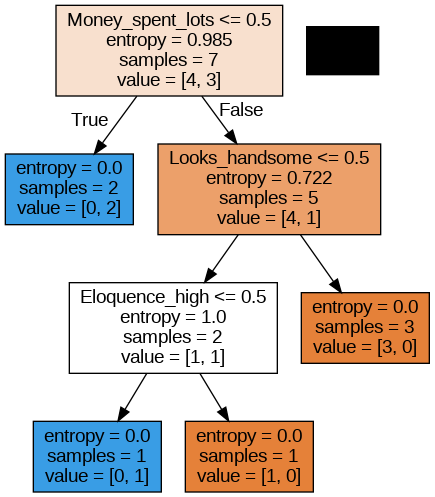

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread('task1.png')
cv2_imshow(img)

## Part 2

Part 2. Functions for calculating entropy and information gain

In [ ]:
# Consider the following warm-up example: we have 9 blue balls and 11 yellow balls. 
# Let ball have label 1 if it is blue, 0 otherwise.

balls = [1 for i in range(9)] + [0 for i in range(11)]

In [ ]:
# Next split the balls into two groups:

# two groups
balls_left = [1 for i in range(8)] + [0 for i in range(5)]  # 8 blue and 5 yellow
balls_right = [1 for i in range(1)] + [0 for i in range(6)]  # 1 blue and 6 yellow

In [ ]:
# Implement a function to calculate the Shannon Entropy

from math import log

def entropy(a_list):
    lst = list(a_list)
    size = len(lst)
    entropy = 0
    set_elements = len(set(lst))
    if set_elements in [0, 1]:
        return 0
    for i in set(lst):
        occ = lst.count(i)
        entropy -= occ / size * log(occ / size, 2)
        
    return entropy

In [ ]:
#  Test

print(entropy(balls))  # 9 blue и 11 yellow
print(entropy(balls_left))  # 8 blue и 5 yellow
print(entropy(balls_right))  # 1 blue и 6 yellow
print(entropy([1, 2, 3, 4, 5, 6]))  # entropy of a fair 6-sided die

0.9927744539878084
0.961236604722876
0.5916727785823275
2.584962500721156


In [ ]:
# information gain calculation

def information_gain(root, left, right):
    """ root - initial data, left and right - two partitions of initial data"""
    result = (
        entropy(root)
        - 1.0 * len(left) / len(root) * entropy(left)
        - 1.0 * len(right) / len(root) * entropy(right)
        )

    return result

In [ ]:
print(information_gain(balls, balls_left, balls_right))

0.16088518841412436


In [ ]:
def information_gains(X, y):
    """Outputs information gain when splitting with each feature"""
    out = []
    for i in X.columns:
        out.append(information_gain(y, y[X[i] == 0], y[X[i] == 1]))
    return out

In [ ]:
information_gains(df_train, y)

[0.2916919971380598,
 0.12808527889139454,
 0.12808527889139454,
 0.005977711423774124,
 0.02024420715375619,
 0.46956521111470706,
 0.46956521111470706,
 0.005977711423774124]

In [ ]:
# Implement a decision tree building algorithm by calling information_gains recursively

def btree(X, y, feature_names):
    clf = information_gains(X, y)
    best_feat_id = clf.index(max(clf))
    best_feature = feature_names[best_feat_id]
    print(f"Best feature to split: {best_feature}")

    x_left = X[X.iloc[:, best_feat_id] == 0]
    x_right = X[X.iloc[:, best_feat_id] == 1]
    print(f"Samples: {len(x_left)} (left) and {len(x_right)} (right)")

    y_left = y[X.iloc[:, best_feat_id] == 0]
    y_right = y[X.iloc[:, best_feat_id] == 1]
    entropy_left = entropy(y_left)
    entropy_right = entropy(y_right)
    print(f"Entropy: {entropy_left} (left) and {entropy_right} (right)")
    print("_" * 30 + "\n")
    if entropy_left != 0:
        print(f"Splitting the left group with {len(x_left)} samples:")
        btree(x_left, y_left, feature_names)
    if entropy_right != 0:
        print(f"Splitting the right group with {len(x_right)} samples:")
        btree(x_right, y_right, feature_names)

In [ ]:
btree(df_train, y, df_train.columns)

Best feature to split: Money_spent_little
Samples: 5 (left) and 2 (right)
Entropy: 0.7219280948873623 (left) and 0 (right)
______________________________

Splitting the left group with 5 samples:
Best feature to split: Looks_handsome
Samples: 2 (left) and 3 (right)
Entropy: 1.0 (left) and 0 (right)
______________________________

Splitting the left group with 2 samples:
Best feature to split: Eloquence_high
Samples: 1 (left) and 1 (right)
Entropy: 0 (left) and 0 (right)
______________________________



## Part 3

The “Adult” dataset

Dataset description:

Dataset UCI Adult (no need to download it, we have a copy in the course repository): classify people using demographic data - whether they earn more than $50,000 per year or not.

Feature descriptions:

Age – continuous feature

Workclass – continuous feature

fnlwgt – final weight of object, continuous feature

Education – categorical feature

Education_Num – number of years of education, continuous feature

Martial_Status – categorical feature

Occupation – categorical feature

Relationship – categorical feature

Race – categorical feature

Sex – categorical feature

Capital_Gain – continuous feature

Capital_Loss – continuous feature

Hours_per_week – continuous feature

Country – categorical feature

Target – earnings level, categorical (binary) feature.

In [ ]:
# Reading train and test data


# for Jupyter-book, we copy data from GitHub, locally, to save Internet traffic,
# you can specify the data/ folder from the root of your cloned
# https://github.com/Yorko/mlcourse.ai repo, to save Internet traffic
DATA_PATH = "https://raw.githubusercontent.com/Yorko/mlcourse.ai/master/data/"

In [ ]:
data_train = pd.read_csv(DATA_PATH + "adult_train.csv", sep=";")
data_train.tail()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K
32560,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,>50K


In [ ]:
data_test = pd.read_csv(DATA_PATH + "adult_test.csv", sep=";")
data_test.tail()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
16277,39,Private,215419.0,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0.0,36.0,United-States,<=50K.
16278,64,NaN,321403.0,HS-grad,9.0,Widowed,NaN,Other-relative,Black,Male,0.0,0.0,40.0,United-States,<=50K.
16279,38,Private,374983.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
16280,44,Private,83891.0,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0,United-States,<=50K.
16281,35,Self-emp-inc,182148.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,60.0,United-States,>50K.


In [ ]:
# necessary to remove rows with incorrect labels in test dataset
data_test = data_test[
    (data_test["Target"] == " >50K.") | (data_test["Target"] == " <=50K.")
]

# encode target variable as integer
data_train.loc[data_train["Target"] == " <=50K", "Target"] = 0
data_train.loc[data_train["Target"] == " >50K", "Target"] = 1

data_test.loc[data_test["Target"] == " <=50K.", "Target"] = 0
data_test.loc[data_test["Target"] == " >50K.", "Target"] = 1

In [ ]:
data_test.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,16281,73,35,461,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Workclass,15318,8,Private,11210,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fnlwgt,16281.0,NaN,NaN,NaN,189435.677784,105714.907671,13492.0,116736.0,177831.0,238384.0,1490400.0
Education,16281,16,HS-grad,5283,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education_Num,16281.0,NaN,NaN,NaN,10.072907,2.567545,1.0,9.0,10.0,12.0,16.0
Martial_Status,16281,7,Married-civ-spouse,7403,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Occupation,15315,14,Prof-specialty,2032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relationship,16281,6,Husband,6523,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Race,16281,5,White,13946,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,16281,2,Male,10860,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [118]:
data_train["Target"].value_counts()

0    24720
1     7841
Name: Target, dtype: int64

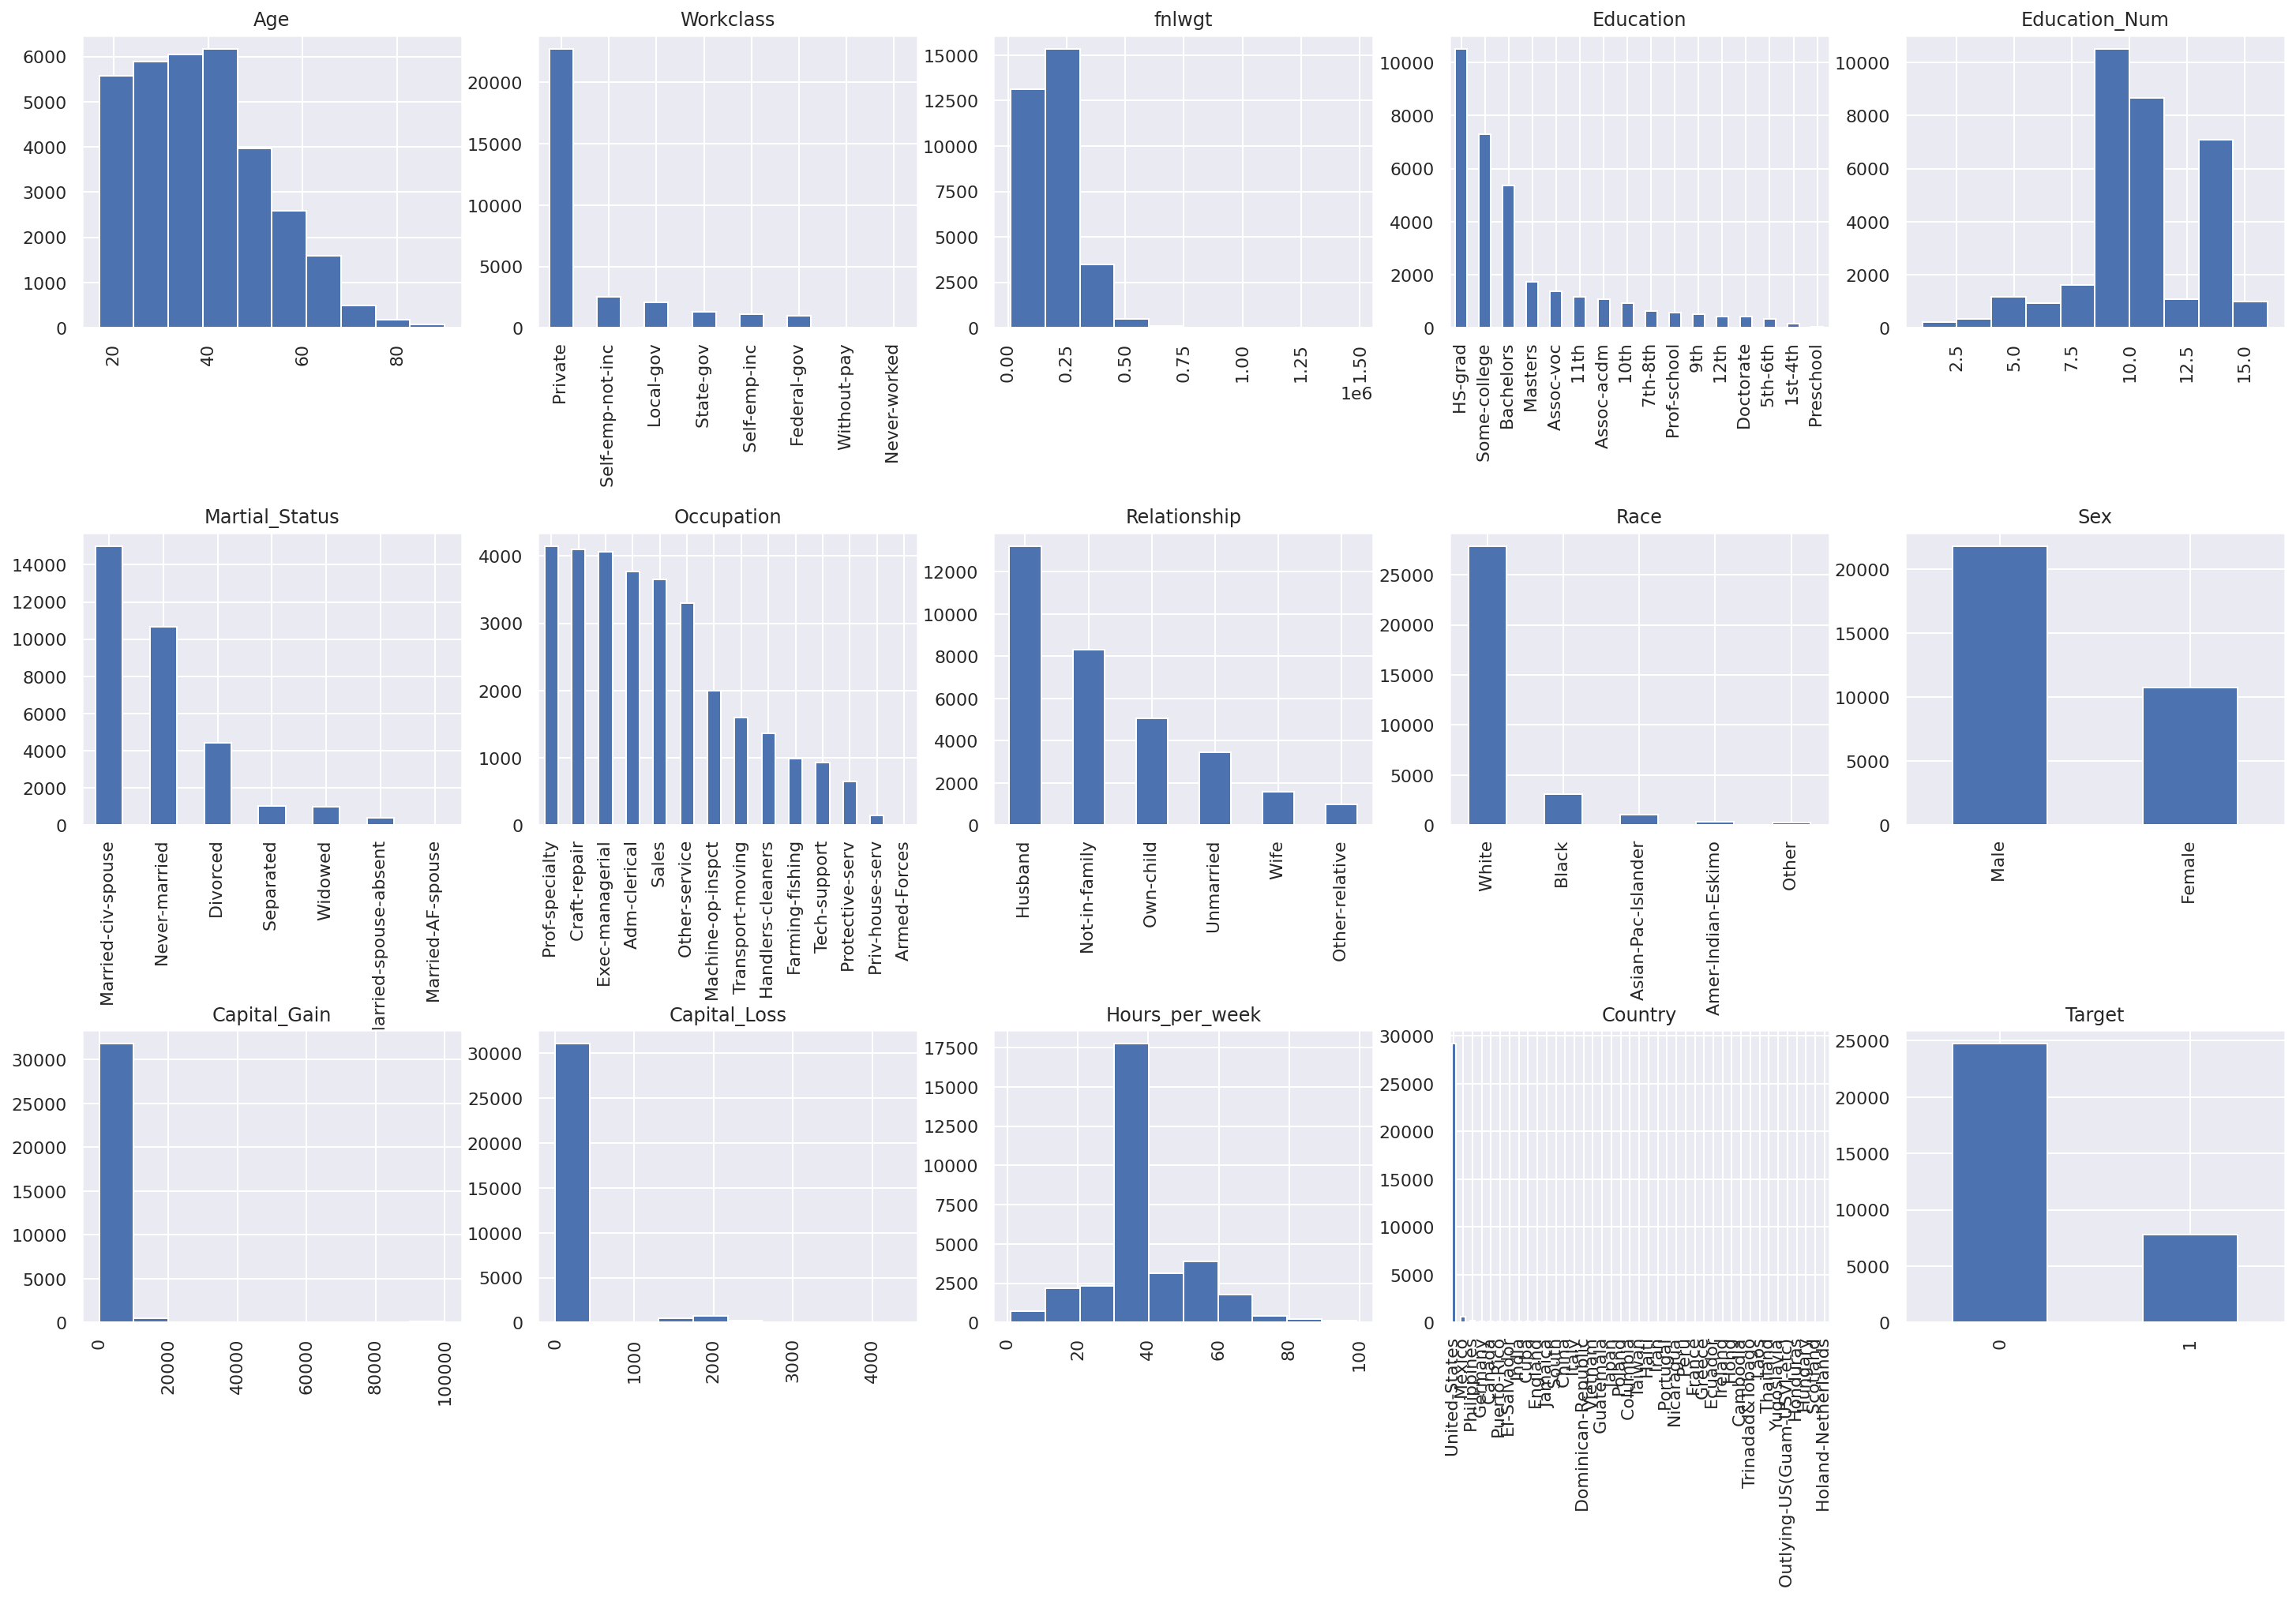

In [ ]:
fig = plt.figure(figsize=(25, 15))
cols = 5
rows = int(data_train.shape[1] / cols)
for i, column in enumerate(data_train.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if data_train.dtypes[column] == object:
        data_train[column].value_counts().plot(kind="bar", axes=ax)
    else:
        data_train[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2);

In [ ]:
data_train.dtypes

Age                int64
Workclass         object
fnlwgt             int64
Education         object
Education_Num      int64
Martial_Status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital_Gain       int64
Capital_Loss       int64
Hours_per_week     int64
Country           object
Target            object
dtype: object

In [ ]:
data_test.dtypes

Age                object
Workclass          object
fnlwgt            float64
Education          object
Education_Num     float64
Martial_Status     object
Occupation         object
Relationship       object
Race               object
Sex                object
Capital_Gain      float64
Capital_Loss      float64
Hours_per_week    float64
Country            object
Target             object
dtype: object

In [119]:
# As we see, in the test data, age is treated as type object. We need to fix this.

data_test["Age"] = data_test["Age"].astype(int)

In [120]:
# Also we’ll cast all float features to int type to keep types consistent between our train and test data.

data_test["fnlwgt"] = data_test["fnlwgt"].astype(int)
data_test["Education_Num"] = data_test["Education_Num"].astype(int)
data_test["Capital_Gain"] = data_test["Capital_Gain"].astype(int)
data_test["Capital_Loss"] = data_test["Capital_Loss"].astype(int)
data_test["Hours_per_week"] = data_test["Hours_per_week"].astype(int)

In [121]:
# Fill in missing data for continuous features with their median values, 
# for categorical features with their mode.

# choose categorical and continuous features from data

categorical_columns = [
    c for c in data_train.columns if data_train[c].dtype.name == "object"
]
numerical_columns = [
    c for c in data_train.columns if data_train[c].dtype.name != "object"
]

print("categorical_columns:", categorical_columns)
print("numerical_columns:", numerical_columns)

categorical_columns: ['Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country', 'Target']
numerical_columns: ['Age', 'fnlwgt', 'Education_Num', 'Capital_Gain', 'Capital_Loss', 'Hours_per_week']


In [122]:
# we see some missing values
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int64 
 1   Workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   Education       32561 non-null  object
 4   Education_Num   32561 non-null  int64 
 5   Martial_Status  32561 non-null  object
 6   Occupation      30718 non-null  object
 7   Relationship    32561 non-null  object
 8   Race            32561 non-null  object
 9   Sex             32561 non-null  object
 10  Capital_Gain    32561 non-null  int64 
 11  Capital_Loss    32561 non-null  int64 
 12  Hours_per_week  32561 non-null  int64 
 13  Country         31978 non-null  object
 14  Target          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [123]:
# fill missing data

for c in categorical_columns:
    data_train[c].fillna(data_train[c].mode()[0], inplace=True)
    data_test[c].fillna(data_train[c].mode()[0], inplace=True)

for c in numerical_columns:
    data_train[c].fillna(data_train[c].median(), inplace=True)
    data_test[c].fillna(data_train[c].median(), inplace=True)

In [124]:
# no more missing values
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int64 
 1   Workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   Education       32561 non-null  object
 4   Education_Num   32561 non-null  int64 
 5   Martial_Status  32561 non-null  object
 6   Occupation      32561 non-null  object
 7   Relationship    32561 non-null  object
 8   Race            32561 non-null  object
 9   Sex             32561 non-null  object
 10  Capital_Gain    32561 non-null  int64 
 11  Capital_Loss    32561 non-null  int64 
 12  Hours_per_week  32561 non-null  int64 
 13  Country         32561 non-null  object
 14  Target          32561 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 3.7+ MB


In [127]:
# We’ll dummy code some categorical features: Workclass, Education, 
# Martial_Status, Occupation, Relationship, Race, Sex, Country. 
# It can be done via pandas method get_dummies

data_train = pd.concat(
    [data_train[numerical_columns], pd.get_dummies(data_train[categorical_columns])],
    axis=1,
)

data_test = pd.concat(
    [data_test[numerical_columns], pd.get_dummies(data_test[categorical_columns])],
    axis=1,
)

In [128]:
data_train

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Target,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,...,Country_ Portugal,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,215646,9,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,53,234721,7,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,28,338409,13,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,257302,12,0,0,38,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
32557,40,154374,9,0,0,40,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
32558,58,151910,9,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
32559,22,201490,9,0,0,20,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [129]:
set(data_train.columns) - set(data_test.columns)

{'Country_ Holand-Netherlands'}

In [130]:
data_train.shape, data_test.shape

((32561, 106), (16281, 105))

In [131]:
# There is no Holland in the test data. Create new zero-valued feature.

data_test["Country_ Holand-Netherlands"] = 0

In [132]:
set(data_train.columns) - set(data_test.columns)

set()

In [133]:
data_train.head(2)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Target,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,...,Country_ Portugal,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [134]:
data_test.head(2)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Target,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,...,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia,Country_ Holand-Netherlands
1,25,226802,7,0,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,38,89814,9,0,0,50,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [135]:
X_train = data_train.drop(["Target"], axis=1)
y_train = data_train["Target"]

X_test = data_test.drop(["Target"], axis=1)
y_test = data_test["Target"]

3.1 Decision tree without parameter tuning

In [136]:
from sklearn.tree import DecisionTreeClassifier

tree3 = DecisionTreeClassifier(max_depth=3, random_state=17)
tree3.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=17)

In [139]:
tree_predictions = tree3.predict(X_test)

In [145]:
acc = accuracy_score(y_test, tree_predictions)
print("Accuracy:", acc)

Accuracy: 0.8447884036607088


3.2 Decision tree with parameter tuning

Train a decision tree (DecisionTreeClassifier, random_state = 17). Find the optimal maximum depth using 5-fold cross-validation (GridSearchCV).

In [151]:
tree_params = {"max_depth": range(2, 11)}

locally_best_tree = GridSearchCV(param_grid=tree_params, 
                                 estimator=DecisionTreeClassifier(random_state=17),
                                 cv=5)

locally_best_tree.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=17),
             param_grid={'max_depth': range(2, 11)})

In [152]:
print("Best params:", locally_best_tree.best_params_)
print("Best cross validaton score", locally_best_tree.best_score_)

Best params: {'max_depth': 9}
Best cross validaton score 0.8565770273854106


In [153]:
tuned_tree = DecisionTreeClassifier(max_depth=9, random_state=17)
tuned_tree.fit(X_train, y_train)
tuned_tree_predictions = tuned_tree.predict(X_test)
accuracy_score(y_test, tuned_tree_predictions)

0.847798046803022

3.3 (Optional) Random forest without parameter tuning

In [154]:
rf = RandomForestClassifier(n_estimators=100, 
                            random_state=17)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=17)

In [158]:
predictions = rf.predict(X_test)
acc = accuracy_score(y_test, predictions)
print("Accuracy:", acc)

Accuracy: 0.8585467723112831


In [162]:
cv_scores = cross_val_score(rf, X_train, y_train, cv=3)
cv_scores, cv_scores.mean()

(array([0.85194398, 0.85572139, 0.859578  ]), 0.8557477912289437)

3.4 (Optional) Random forest with parameter tuning

In [160]:
forest_params = {'max_depth': range(10, 21),
                'max_features': range(5, 105, 20)}

locally_best_forest = GridSearchCV(RandomForestClassifier(random_state=17),
                                   param_grid=forest_params)

locally_best_forest.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(random_state=17),
             param_grid={'max_depth': range(10, 21),
                         'max_features': range(5, 105, 20)})

In [161]:
predictions_gs = rf.predict(X_test)
acc2 = accuracy_score(y_test, predictions_gs)
print("Accuracy:", acc2)

Accuracy: 0.8585467723112831
